In [2]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [3]:
import random

import numpy as np
import pandas as pd

from src.models.dense import NN0
from src.models.dense import NN1
from src.models.gcn import GCN0
from src.models.gcn import GCN1
from src.models.gcn import GCN_fix_2layer
from src.models.gat import GAT

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_ce_ce
from src.models.reg import make_lap_loss_ce

from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test
from tqdm import tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

A_hat = compute_a_hat(data)

# data = random_splits(data, 50, 20)
data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)


In [5]:
data.train_mask.sum()
data.val_mask.sum()
data.test_mask.sum()

tensor(1000)

In [6]:
print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'val size: {data.val_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')

metrics = []
for seed in range(5):
    for loss_fn_name in ['lap_loss', 'preg_loss']:
        for model_name in ['gcn', 'mlp']:
            for mu in range(11):
                torch.manual_seed(seed)
                random.seed(seed)

                mu = mu / 10

                if loss_fn_name == 'lap_loss':
                    loss_fn = make_lap_loss_ce(mu)
                elif loss_fn_name == 'preg_loss':
                    loss_fn = make_preg_ce_ce(mu, A_hat)
                else:
                    raise(Exception('Not Implemented'))
                
                if model_name == 'gcn':
                    model = GCN_fix_2layer() \
                        .to(device)
                elif model_name == 'mlp':
                    model = NN1(num_node_features=dataset.num_node_features,
                        num_classes=dataset.num_classes) \
                        .to(device)
                else:
                    raise(Exception('Not Implemented'))


                model = train_with_loss(model, data, loss_fn, num_epochs=200)

                acc = evaluate0(model, data)

                train_acc, val_acc, test_acc = evaluate1(model, data)
                metrics.append({'model': model_name, 'reg': loss_fn_name, 'seed': seed, 'mu': mu, 'train_acc': np.round(train_acc,4), 'val_acc': np.round(val_acc,4), 'test_acc': np.round(test_acc,4)})
                print(metrics[-1])
                # print(f'mu: {mu}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}')
                # print('-------------------------------------------------------------')


-------------------------------------------------------------
train size: 140
val size: 500
test size: 1000
-------------------------------------------------------------
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.0, 'train_acc': 0.9929, 'val_acc': 0.794, 'test_acc': 0.803}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.1, 'train_acc': 0.9929, 'val_acc': 0.65, 'test_acc': 0.675}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.2, 'train_acc': 0.9929, 'val_acc': 0.61, 'test_acc': 0.621}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.3, 'train_acc': 0.9929, 'val_acc': 0.608, 'test_acc': 0.6}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.4, 'train_acc': 0.9929, 'val_acc': 0.588, 'test_acc': 0.577}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.5, 'train_acc': 0.9857, 'val_acc': 0.57, 'test_acc': 0.563}
{'model': 'gcn', 'reg': 'lap_loss', 'seed': 0, 'mu': 0.6, 'train_acc': 0.9857, 'val_acc': 0.568, 'test_acc': 0.575}
{'model': 'gcn', 'reg':

ValueError: x and y must have same first dimension, but have shapes (55,) and (9, 5)

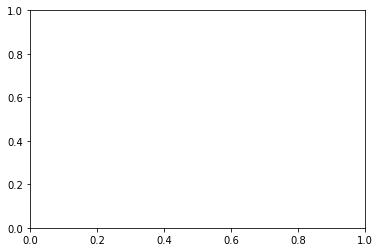

In [8]:
df = pd.DataFrame(metrics)
df.to_csv('reports/figures/fig2c_alt.csv')
fig, ax = plt.subplots()

filt = (df['model'] == 'gcn') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], 9*[df[filt]['test_acc'][df[filt]['mu']==0]], '--b')

filt = (df['model'] == 'mlp') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], 9*[df[filt]['test_acc'][df[filt]['mu']==0]], '--r')

filt = (df['model'] == 'gcn') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*b')

filt = (df['model'] == 'mlp') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*r')

filt = (df['model'] == 'gcn') & (df['reg'] == 'lap_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-ob', label='GCN')

filt = (df['model'] == 'mlp') & (df['reg'] == 'lap_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-or', label='MLP')

ax.set(ylim=(.5, .9), xlabel='Regularization factor $\mu$', ylabel='Test accuracy')
ax.legend()
plt.show()

In [ ]:
dataset.num_classes

7